# MRI Series 2D Classifier Training

*This notebook is based on the MONAI [Medical Image Classification Tutorial with the MedNIST Dataset](https://github.com/Project-MONAI/tutorials/blob/master/2d_classification/mednist_tutorial.ipynb). There are more tutorials in the MOINAI repository released under a [permissive license](https://github.com/Project-MONAI/tutorials/blob/master/LICENSE).*

DenseNet (Dense Convolutional Network) is a neural network architecture from 2017 that was jointly invented by Cornwell University, Tsinghua University and Facebook AI Research (FAIR). DenseNet variations are widely accepted and show strong performance in classification tasks.

This notebook shows how to train a DenseNet using the dataset that we have stored in our Cloud Storage Bucket.

## Procedure

The training procedure is the following:

1. Download, unpack and check the dataset
2. Split the dataset into training, validation and test data lists
3. Initialize custom PyTorch Dataset and a DenseNet model
4. Perform model training and validation
5. Test the trained model on testing data
6. Save the results to a Cloud Storage Bucket

### Environvent variables and imports

In [ ]:
myProjectID = '%%PUT-YOUR-PROJECT-ID-HERE%%'
bucket_name = '%%PUT-YOUR-BUCKET-ID-HERE%%'

In [ ]:
# Colab specific authentication helpers
from google.colab import auth

auth.authenticate_user()

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 573kB 31.8MB/s 
     |████████████████████████████████| 81kB 11.4MB/s 


In [ ]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import compute_roc_auc
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.utils import set_determinism

%matplotlib inline

print_config()

MONAI version: 0.6.dev2126
Numpy version: 1.19.5
Pytorch version: 1.9.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 2ad54662de25e9a964c33327f7f2f178655573ef

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.5.0
gdown version: 3.6.4
TorchVision version: 0.10.0+cu102
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.61.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



### Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
data_dir = '/tmp/data/'
!rm -rf $data_dir && mkdir -p $data_dir
print(data_dir)

/tmp/data/


### Download dataset

In [ ]:
resource = 'gs://pw35-data-001/pw5-gba-tagging-data.zip'
!gsutil -u $myProjectID cp $resource $data_dir

!unzip -o "$data_dir"pw5-gba-tagging-data.zip

!mv -f images/* $data_dir
!rm "$data_dir"pw5-gba-tagging-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/T2-WEIGHTED_IMAGE_FLAIR/40110519-28a6-4696-be67-e673f9f35fa6.jpg  
  inflating: images/T2-WEIGHTED_IMAGE_FLAIR/b5ab511c-b5e8-424d-835e-d211f7a713a2.jpg  
  inflating: images/T2-WEIGHTED_IMAGE_FLAIR/3ebefab0-328c-430c-a3e0-de2ba34944c1.jpg  
  inflating: images/T2-WEIGHTED_IMAGE_FLAIR/27ebb2ce-9974-4cb3-b451-7e088c0c1637.jpg  
  inflating: images/T2-WEIGHTED_IMAGE_FLAIR/b7bf0b79-4ea4-4604-bb7c-b01fb310599f.jpg  
  inflating: images/T2-WEIGHTED_IMAGE_FLAIR/4c800c15-d45d-486d-aee3-cedbd57c0481.jpg  
  inflating: images/T2-WEIGHTED_IMAGE_FLAIR/2fbbd306-cf40-472e-b1ba-99d9de40361d.jpg  
  inflating: images/T2-WEIGHTED_IMAGE_FLAIR/b4b7f9a9-7335-43e8-91de-1e936d1b3fe3.jpg  
  inflating: images/T2-WEIGHTED_IMAGE_FLAIR/0a91c144-28c7-4c5d-80e8-d7140752bcbf.jpg  
  inflating: images/T2-WEIGHTED_IMAGE_FLAIR/c50ca328-9d2e-418e-ac04-7cbbaa82335a.jpg  
  inflating: images/T2-WEIGHTED_IMAGE_FLAIR/9a2a02b6-d5dc-4380-9838-f6896eefc25

### Set deterministic training for reproducibility

In [ ]:
set_determinism(seed=0)

### Read image filenames from the dataset folders

First of all, check the dataset files and show some statistics.  
There are 4 folders in the dataset: 

- `T2-WEIGHTED_IMAGE_FLAIR`
- `T1-WEIGHTED_POST-CONTRAST`
- `T1-WEIGHTED_PRE-CONTRAST`
- `T2-WEIGHTED_IMAGE`

The names of these folders should be used as the labels to train our classification model.

In [ ]:
class_names = sorted(x for x in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 40000
Image dimensions: 64 x 64
Label names: ['T1-WEIGHTED_POST-CONTRAST', 'T1-WEIGHTED_PRE-CONTRAST', 'T2-WEIGHTED_IMAGE', 'T2-WEIGHTED_IMAGE_FLAIR']
Label counts: [10000, 10000, 10000, 10000]


### Randomly pick images from the dataset to visualize and check

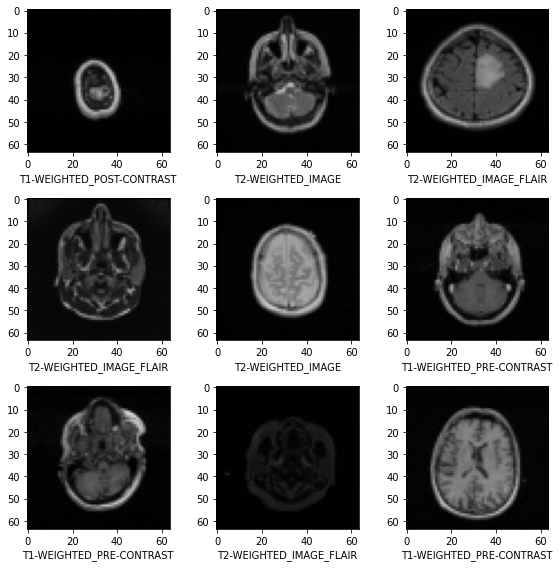

In [ ]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

### Prepare training, validation and test data lists

Randomly select 10% of the dataset as validation and 10% as test.

In [ ]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 32000, Validation count: 4000, Test count: 4000


### Define MONAI transforms, Dataset and Dataloader to pre-process data

In [ ]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
    ]
)

val_transforms = Compose(
    [LoadImage(image_only=True),
     ScaleIntensity(),
     ToTensor()])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=True, n_classes=num_class)

In [ ]:
class MRISeriesDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        tensor, label = self.transforms(self.image_files[index]), self.labels[index]
        tensor = tensor[:, :, 0:1]
        tensor = tensor.permute(2, 0, 1)
        return tensor, label


train_ds = MRISeriesDataset(train_x, train_y, train_transforms)
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=300, shuffle=True, num_workers=30)

val_ds = MRISeriesDataset(val_x, val_y, val_transforms)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=300, num_workers=30)

test_ds = MRISeriesDataset(test_x, test_y, val_transforms)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=300, num_workers=30)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 30 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Define network and optimizer

1. Set learning rate for how much the model is updated per batch.
2. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.  
DenseNet models can show strong performance if trained for 50-100 epochs. We'll use 70 epochs in this example. 
3. Use DenseNet from MONAI and move to GPU devide, this DenseNet can support both 2D and 3D classification tasks.
4. Use Adam optimizer.

In [ ]:
device = torch.device("cuda")
model = DenseNet121(spatial_dims=2, in_channels=1,
                    out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 70
val_interval = 1

### Model training

Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.  
Will save the model weights to file if got best validation accuracy.

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = to_onehot(y)
            y_pred_act = act(y_pred)
            auc_metric = compute_roc_auc(y_pred_act, y_onehot)
            del y_pred_act, y_onehot
            metric_values.append(auc_metric)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if auc_metric > best_metric:
                best_metric = auc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    data_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {auc_metric:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/70


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 30 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Streaming output truncated to the last 5000 lines.
18/106, train_loss: 0.2790
19/106, train_loss: 0.2877
20/106, train_loss: 0.1771
21/106, train_loss: 0.2643
22/106, train_loss: 0.2465
23/106, train_loss: 0.2988
24/106, train_loss: 0.2283
25/106, train_loss: 0.2071
26/106, train_loss: 0.1916
27/106, train_loss: 0.2944
28/106, train_loss: 0.2070
29/106, train_loss: 0.2205
30/106, train_loss: 0.3235
31/106, train_loss: 0.2984
32/106, train_loss: 0.2332
33/106, train_loss: 0.2475
34/106, train_loss: 0.2933
35/106, train_loss: 0.2300
36/106, train_loss: 0.2156
37/106, train_loss: 0.2391
38/106, train_loss: 0.2812
39/106, train_loss: 0.2071
40/106, train_loss: 0.2329
41/106, train_loss: 0.2352
42/106, train_loss: 0.2188
43/106, train_loss: 0.3034
44/106, train_loss: 0.2107
45/106, train_loss: 0.2355
46/106, train_loss: 0.2255
47/106, train_loss: 0.2251
48/106, train_loss: 0.2751
49/106, train_loss: 0.2698
50/106, train_loss: 0.2415
51/106, train_loss: 0.2365
52/106, train_loss: 0.2485
53/1

### Plot the loss and metric

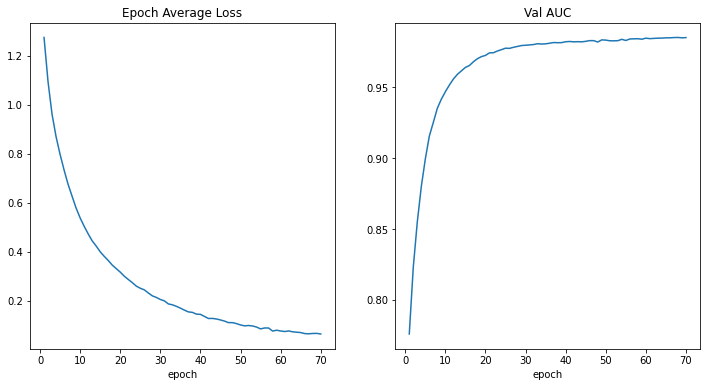

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluate the model on test dataset

After training and validation, we already got the best model on validation test.  
We need to evaluate the model on test dataset to check whether it's robust and not over-fitting.  
We'll use these predictions to generate a classification report.

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(data_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 30 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4))

                           precision    recall  f1-score   support

T1-WEIGHTED_POST-CONTRAST     0.9054    0.8981    0.9017       981
 T1-WEIGHTED_PRE-CONTRAST     0.8340    0.8870    0.8597       991
        T2-WEIGHTED_IMAGE     0.9404    0.8902    0.9146      1011
  T2-WEIGHTED_IMAGE_FLAIR     0.9065    0.9056    0.9061      1017

                 accuracy                         0.8952      4000
                macro avg     0.8966    0.8952    0.8955      4000
             weighted avg     0.8968    0.8952    0.8957      4000



## Upload the model to GCS

In [ ]:
!gsutil -u $myProjectID cp /tmp/data/best_metric_model.pth gs://$bucket_name/

Copying file:///tmp/data/best_metric_model.pth [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/27.1 MiB.                                     
